In [ ]:
from google.colab import drive
drive_root = '/content/drive'
drive.mount(drive_root, force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
import os

project_root = os.path.join(drive_root, 'MyDrive/Colab Notebooks/cmpe540/final-project')
source_root = os.path.join(project_root, 'src')
sys.path.append(source_root)
data_folder_path = os.path.join(project_root, 'data')
raw_data_folder_path = os.path.join(data_folder_path, 'raw')
processed_data_folder_path = os.path.join(data_folder_path, 'processed')
train_data_path = os.path.join(processed_data_folder_path, "train_data.csv")

In [ ]:
import pandas as pd

# Read the data, carry out final changes
full_set = pd.read_csv(train_data_path)
full_set = full_set.drop(['flightDate'], axis=1)
full_set['isNonStop'] = full_set['isNonStop'].astype(int)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define the dataset
class TicketPriceDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the model
class TicketPriceModel(nn.Module):
    def __init__(self):
      super(TicketPriceModel, self).__init__()
      # 3-layer LSTM block
      self.lstm = nn.LSTM(input_size=36, hidden_size=64, num_layers=3, batch_first=True)

      # 3-layer 1D Conv block
      self.conv1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
      self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

      # Fully connected layers
      # Calculate the input size dynamically based on the output of the convolutional layers
      self.fc1_input_size = self._get_fc1_input_size(torch.randn(1, 36))  # Pass a dummy input to calculate size
      self.fc1 = nn.Linear(self.fc1_input_size, 128)
      self.fc2 = nn.Linear(128, 1)  # Output: ticket price

      # Activation function
      self.relu = nn.ReLU()

    def _get_fc1_input_size(self, x):
      """Calculates the input size for fc1 based on a dummy input."""
      x, _ = self.lstm(x)
      if x.dim() == 2:
        x = x.unsqueeze(1)
      x = x.permute(0, 2, 1)
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.conv3(x)
      x = F.relu(x)
      return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
      # LSTM block
      x, _ = self.lstm(x)

      # Check if x has 3 dimensions, if not, add a dimension
      if x.dim() == 2:  # If x has only 2 dimensions
        x = x.unsqueeze(1)  # Add a dimension at position 1

      # Permute for Conv1D: (batch_size, channels=64, seq_length)
      x = x.permute(0, 2, 1)

      # Pass through Conv layers
      x = self.conv1(x)  # -> (batch_size, 32, seq_length')
      x = F.relu(x)
      x = self.conv2(x)  # -> (batch_size, 16, seq_length'')
      x = F.relu(x)
      x = self.conv3(x)  # -> (batch_size, 16, seq_length''')
      x = F.relu(x)


      # Flatten for fully connected layers
      x = x.view(x.size(0), -1)  # (batch_size, 64 * 16)

      # Fully-connected layers
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)  # -> (batch_size, 1)

      return x


In [ ]:
from tqdm import tqdm
import time
from datetime import datetime, timedelta


# Training flow
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, device, results_dir): # Add device parameter
    # File paths for saving loss data
    epoch_loss_file = os.path.join(results_dir, "epoch_losses.txt")
    epoch_losses = []

    model.train()
    for epoch in range(num_epochs):
      start_time = time.time()
      epoch_loss = 0.0

      for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs.squeeze(), targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        epoch_loss += loss.item()

      # Epoch summary metrics
      current_lr = optimizer.param_groups[0]['lr']
      epoch_duration = time.time() - start_time
      epoch_loss /= len(dataloader)
      epoch_losses.append(epoch_loss)
      print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {current_lr}, Loss: {epoch_loss}")

      with open(epoch_loss_file, "a") as f:
        # Save epoch summary
        epoch_summary = (
          f"Epoch [{epoch + 1}/{num_epochs}] completed in {str(timedelta(seconds=int(epoch_duration)))}\n"
          f"Learning Rate: {current_lr}"
          f"Average Loss: {epoch_loss:.4f}\n"
        )

        # Print to console
        print(epoch_summary.strip())

        # Write to file
        f.write(epoch_summary)

    # Save model
    model_save_path = os.path.join(results_dir, 'final_trained_model.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Final trained model saved to: {model_save_path}")

    # Save and display the training loss plot
    import matplotlib.pyplot as plt
    plot_filename_drive = os.path.join(results_dir, 'training_loss_plot.png')
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.savefig(plot_filename_drive)
    print(f"Training loss plot saved to Google Drive at {plot_filename_drive}")
    plt.show()


In [ ]:
# Define split ratio
train_ratio = 0.8

# Compute split index
split_index = int(len(full_set) * train_ratio)

# Split the data
train_set = full_set.iloc[:split_index]
test_set = full_set.iloc[split_index:]


In [ ]:
batch_size = 256

from torch.utils.data import DataLoader


train_loader = DataLoader(
  TicketPriceDataset(train_set.drop(columns=['baseFare']).values, train_set['baseFare'].values),
  batch_size=batch_size,
  shuffle=False  # No shuffling for time series
)

test_loader = DataLoader(
  TicketPriceDataset(test_set.drop(columns=['baseFare']).values, test_set['baseFare'].values),
  batch_size=batch_size,
  shuffle=False
)


In [ ]:
import torch.optim as optim


# Hyperparameters
batch_size = 256
learning_rate = 0.00002
num_epochs = 20

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = TicketPriceModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [ ]:
from datetime import datetime
import os

## Artifact paths (checkpoints, plots, metrics)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(project_root, 'results', timestamp)

# Ensure artifact paths exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f'Directory created at {results_dir}')
else:
  print(f'Directory {results_dir} already exists.')

Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_141512


Epoch 1/20, Learning Rate: 2e-05, Loss: 132105.61660810406
Epoch [1/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 132105.6166


Epoch 2/20, Learning Rate: 2e-05, Loss: 123845.9917576256
Epoch [2/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 123845.9918


Epoch 3/20, Learning Rate: 2e-05, Loss: 108168.96007307865
Epoch [3/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 108168.9601


Epoch 4/20, Learning Rate: 2e-05, Loss: 85101.54129597788
Epoch [4/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 85101.5413


Epoch 5/20, Learning Rate: 2e-05, Loss: 58727.87039637224
Epoch [5/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 58727.8704


Epoch 6/20, Learning Rate: 2e-05, Loss: 36375.588061172995
Epoch [6/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 36375.5881


Epoch 7/20, Learning Rate: 2e-05, Loss: 23509.262057509717
Epoch [7/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 23509.2621


Epoch 8/20, Learning Rate: 2e-05, Loss: 18890.56950414922
Epoch [8/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 18890.5695


Epoch 9/20, Learning Rate: 2e-05, Loss: 17795.58281623804
Epoch [9/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17795.5828


Epoch 10/20, Learning Rate: 2e-05, Loss: 17568.918738552256
Epoch [10/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17568.9187


Epoch 11/20, Learning Rate: 2e-05, Loss: 17518.692664333506
Epoch [11/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17518.6927


Epoch 12/20, Learning Rate: 2e-05, Loss: 17507.555492346368
Epoch [12/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17507.5555


Epoch 13/20, Learning Rate: 2e-05, Loss: 17505.272490140924
Epoch [13/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.2725


Epoch 14/20, Learning Rate: 2e-05, Loss: 17505.34696821733
Epoch [14/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.3470


Epoch 15/20, Learning Rate: 2e-05, Loss: 17505.487738066313
Epoch [15/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.4877


Epoch 16/20, Learning Rate: 2e-05, Loss: 17505.675649250523
Epoch [16/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.6756


Epoch 17/20, Learning Rate: 2e-05, Loss: 17505.73328746449
Epoch [17/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.7333


Epoch 18/20, Learning Rate: 2e-05, Loss: 17505.704728852048
Epoch [18/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.7047


Epoch 19/20, Learning Rate: 2e-05, Loss: 17505.61297753439
Epoch [19/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.6130


Epoch 20/20, Learning Rate: 2e-05, Loss: 17505.517311789772
Epoch [20/20] completed in 0:00:02
Learning Rate: 2e-05Average Loss: 17505.5173
Final trained model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_141512/final_trained_model.pth
Training loss plot saved to Google Drive at /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_141512/training_loss_plot.png


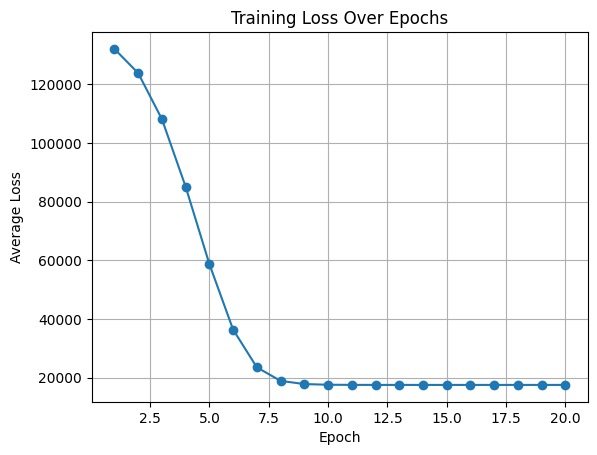

In [ ]:
# Train the model
train_model(model, train_loader, optimizer, loss_fn, num_epochs, device, results_dir)